In [1]:
ga_update = 1

In [2]:
if ga_update:
  !pip install auto-sklearn
  !python -m pip install dask distributed --upgrade

     |████████████████████████████████| 6.1MB 16.9MB/s 
     |████████████████████████████████| 22.3MB 2.2MB/s 
     |████████████████████████████████| 727kB 38.9MB/s 
     |████████████████████████████████| 4.2MB 31.1MB/s 
     |████████████████████████████████| 4.0MB 33.7MB/s 
     |████████████████████████████████| 266kB 48.2MB/s 
  Created wheel for auto-sklearn: filename=auto_sklearn-0.12.6-cp37-none-any.whl size=6370105 sha256=bed4e65d0d8d20aba6ac5635cff5c47c45c293c157b794174f013de1e9ee97e7
  Stored in directory: /root/.cache/pip/wheels/5f/c8/1f/3a6d11c1e156bf431e7cc4c4ff27e71059acc9638caa11ab35
  Created wheel for liac-arff: filename=liac_arff-2.5.0-cp37-none-any.whl size=11732 sha256=ea7747951ab94c3762e0ccdad328da63aaad8e1854052ec27b4ff0711fade149
  Stored in directory: /root/.cache/pip/wheels/77/8d/b4/8bfce5beea9a3496cc15b24961876adb7b6e2912ff09164179
  Created wheel for pynisher: filename=pynisher-0.6.4-cp37-none-any.whl size=7045 sha256=11faffd65bda837a5e3d2642380e6d93853f65

## Library imports

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import autosklearn.classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import plot_precision_recall_curve

import joblib

import random
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')

## Selección de features importantes

In [2]:
important_features = ['X30',
 'X90',
 'X43',
 'X40',
 'X19',
 'X59',
 'X57',
 'X92',
 'X23',
 'X38',
 'X35',
 'X86',
 'X93',
 'X37',
 'X16',
 'X65',
 'X17',
 'X9',
 'X14',
 'X1',
 'X34',
 'X18',
 'X87',
 'X3',
 'X10',
 'X95',
 'X36',
 'X53',
 'X69',
 'X74',
 'X46',
 'X91',
 'X47',
 'X54',
 'X62',
 'X68',
 'X78',
 'X31',
 'X58',
 'X12',
 'X51',
 'X7',
 'X28',
 'X66',
 'X81',
 'X44',
 'X29',
 'X49',
 'X52',
 'X8',
 'X33',
 'X32',
 'X88',
 'X42',
 'X79',
 'X71',
 'X22',
 'X50',
 'X48',
 'X20',
 'X26',
 'X24',
 'X2',
 'X89',
 'X80',
 'X82',
 'X27',
 'X5',
 'X4',
 'X11']

In [5]:
# se carga dataset imputado
imputed_df = pd.read_pickle('dataset_normalizado.pkl')

In [6]:
# función para separar las columnas en variables y etiquetas ('flag')
def split_features(df,features):
    feature_dfs = df[features]
    label_dfs = df['flag']
    return feature_dfs, label_dfs

## Fit

In [7]:
# hacemos la division del dataframe en variables y etiquetas
X, y = split_features(imputed_df,important_features)

# Dividimos la data en test y train
X_train, X_test, y_train, y_test = train_test_split(X, y, \
            stratify = y,test_size = 0.2,random_state=1)

In [9]:
cls = autosklearn.classification.AutoSklearnClassifier(ensemble_nbest=10)
cls.fit(X_train, y_train)

AutoSklearnClassifier(ensemble_nbest=10, per_run_time_limit=360)

In [10]:
cls.show_models()

"[(0.280000, SimpleClassificationPipeline({'balancing:strategy': 'none', 'classifier:__choice__': 'gradient_boosting', 'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessing:numerical_transformer:imputation:strategy': 'most_frequent', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'quantile_transformer', 'feature_preprocessor:__choice__': 'no_preprocessing', 'classifier:gradient_boosting:early_stop': 'train', 'classifier:gradient_boosting:l2_regularization': 1.3412512235813081e-08, 'classifier:gradient_boosting:learning_rate': 0.10000000000000002, 'classifier:gradient_boosting:loss': 'auto', 'classifier:gradient_boosting:max_bins': 255, 'classifier:gradient_boosting:max_depth': 'None', 'classifier:gradient_boosting:max_leaf_nodes': 40, 'classifier:gradient_boosting:min_samples_leaf': 14, 'classifier:gradient

In [12]:
joblib.dump(cls, os.path.join('modelos','Modelo_AUTO-SK.pkl'))

['modelos/Modelo_AUTO-SK.pkl']

## Evaluación

In [13]:
def save_and_show_resultados(descripcion, model, resultados, X_train, X_test, y_train, y_test):
  y_train_pred = model.predict(X_train)
  y_train_pred_proba = model.predict_proba(X_train)[:,1]

  y_test_pred = model.predict(X_test)
  y_test_pred_proba = model.predict_proba(X_test)[:,1]

  confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
  confusion_matrix_test = confusion_matrix(y_test, y_test_pred)

  resultados.update( { descripcion: {
      ('Entrenamiento', 'Exactitud'): model.score(X_train, y_train),
      ('Entrenamiento', 'F1'): f1_score(y_train, y_train_pred),
      ('Entrenamiento', 'AUC'): roc_auc_score(y_train, y_train_pred_proba),
      ('Entrenamiento', 'TypeI'): confusion_matrix_train[0][1],
      ('Pruebas', 'Exactitud'): model.score(X_test, y_test),
      ('Pruebas', 'F1'): f1_score(y_test, y_test_pred),
      ('Pruebas', 'AUC'): roc_auc_score(y_test, y_test_pred_proba),
      ('Pruebas', 'TypeI'): confusion_matrix_test[0][1]
    } } )
  fig, axes = plt.subplots(1, 3, figsize=(18, 5))
  fig.suptitle(f'{descripcion} (Conjunto de Pruebas)')
  plot_confusion_matrix(model, X_test, y_test, ax=axes[0], values_format='d')
  plot_roc_curve(model, X_test, y_test, ax=axes[1], name=descripcion)
  plot_precision_recall_curve(model, X_test, y_test, ax=axes[2], name=descripcion)
  return

In [7]:
predictions = cls.predict(X_test)

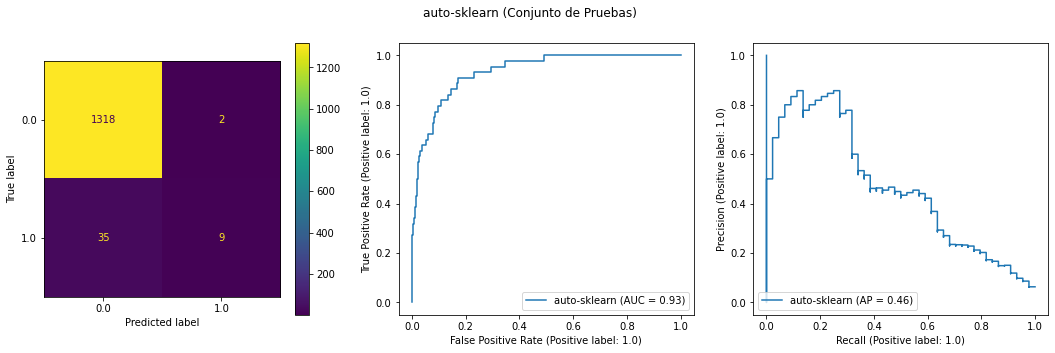

In [14]:
resultados = {}
save_and_show_resultados('auto-sklearn', cls, resultados, X_train, X_test, y_train, y_test)

In [15]:
def tabla_resultados(resultados):
  df = pd.DataFrame.from_dict(resultados, orient='index')
  display(df)
  return df
tabla_resultados(resultados)

Entrenamiento                    ...   Pruebas                
                 Exactitud        F1     AUC  ...        F1       AUC TypeI
auto-sklearn      0.991017  0.841424  0.9807  ...  0.327273  0.933574     2

[1 rows x 8 columns]

Entrenamiento                    ...   Pruebas                
                 Exactitud        F1     AUC  ...        F1       AUC TypeI
auto-sklearn      0.991017  0.841424  0.9807  ...  0.327273  0.933574     2

[1 rows x 8 columns]